# Outlook
In this notebook, using BBRL, we code a simple version of the DQN algorithm
without a replay buffer nor a target network so as to better understand the
inner mechanisms.

To understand this code, you need to know more about 
[the BBRL interaction model](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing).
Then you should run [a first example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
to see how agents interact.

The DQN algorithm is explained in [this
video](https://www.youtube.com/watch?v=CXwvOMJujZk) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/dqn.pdf).

## Installation and Imports

The BBRL library is [here](https://github.com/osigaud/bbrl).

Below, we import standard python packages, pytorch packages and gymnasium
environments.

In [ ]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install easypip")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

In [ ]:
import os
import sys
from pathlib import Path
import math

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime
OmegaConf.register_new_resolver(
    "current_time", lambda: strftime("%Y%m%d-%H%M%S"), replace=True
)


testing_mode = os.environ.get("TESTING_MODE", None) == "ON"

In [ ]:
# Imports all the necessary classes and functions from BBRL
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ... 
# 
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

In [ ]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [ ]:
if not is_notebook():
    print("Not displaying video (hidden since not in a notebook)", file=sys.stderr)
    def video_display(*args, **kwargs):
        pass
    def display(*args, **kwargs):
        print(*args, **kwargs) 
    
testing_mode = os.environ.get("TESTING_MODE", None) == "ON"

## Definition of agents

After running the simple BBRL interaction notebook pointed to above, have a
look at [this more advanced
notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
where the agents is a simple random agent and the environment agent is [the
CartPole-v1 gym
environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).
We provide just a few details below.

In BBRL, the agent and the environment act within a **workspace** by *reading*
and *writing* information:

- **reading**: by using `self.get((key, t))` to get the value of the tensor
  identified by `key` (a string)
- **writing**: by using `self.set((key, t), y)` to set the value of the tensor
  identified by `key` to `y`

**WARNING**: we are working with batches (i.e. several episodes at the same
time)

An episode is depicted in the figure below.

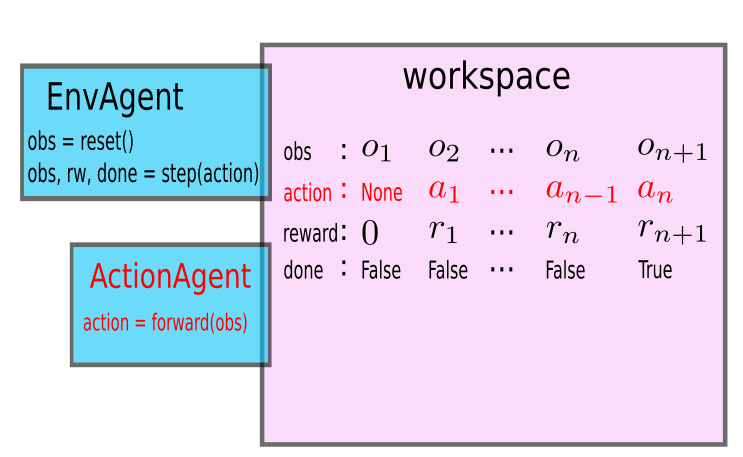

Note that, as depicted below, the reward indexing scheme we use here consists in getting $r_{t+1}$ after performing action $a_t$ from state $s_t$.

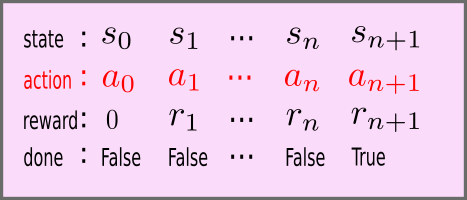

[This notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing#scrollTo=qXvH0jNADUsY) explains that another choice is possible.

To showcase BBRL, let us go through the CartPole environment

In [ ]:
# We run episodes over 3 environments at a time
n_envs = 3
env_agent = ParallelGymAgent(partial(make_env, 'CartPole-v1', autoreset=False), n_envs, reward_at_t=False)
# The random seed is set to 2139
env_agent.seed(2139)

obs_size, action_dim = env_agent.get_obs_and_actions_sizes()
print(f"Environment: observation space in R^{obs_size} and action space {{1, ..., {action_dim}}}")

In [ ]:
# Creates a new workspace
workspace = Workspace() 

# Execute the first step
env_agent(workspace, t=0)

# Our first set of observations. The size of the observation space is 4, and we have 3 environments.
obs = workspace.get("env/env_obs", 0)
print("Observation", obs)

### Random action without agent
We first set an action directly without using an agent

In [ ]:
# Sets the next action
action = torch.randint(0, action_dim, (n_envs, ))
workspace.set("action", 0, action)
print(action)
env_agent(workspace, t=1)

# And perform one step
workspace.get("env/env_obs", 1)

Let us now see the workspace

In [ ]:
for key in workspace.variables.keys():
    print(key, workspace[key])

You can observe that we have two time steps for each variable that are stored
within tensors where the first dimension is time. 

### Random agent

The process above can be
automatized with `Agents` and `TemporalAgent` as shown below - but first we have
to create an agent that selects the actions (here, random).

In [ ]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)

# Each agent is run in the order given when constructing Agents
agents = Agents(env_agent, RandomAgent(action_dim))

# And the TemporalAgent allows to run through time
t_agents = TemporalAgent(agents)

In [ ]:
# We can now run the agents throught time with a simple call...

workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)

### Termination

`env/done` tells us if the episode was finished or not
here, with NoAutoReset, (1) we wait that all episodes are "done",
and when an episode is finished the flag remains True.
Note that when an environment is done before the others, its content is copied until the termination of all environments.
This is convenient for collecting the final reward.

In [ ]:
workspace["env/done"].shape, workspace["env/done"][-10:]

The resulting tensor of observations, with the last two observations

In [ ]:
workspace["env/env_obs"].shape, workspace["env/env_obs"][-2:]

The resulting tensor of rewards, with the last 8 rewards

In [ ]:
workspace["env/reward"].shape, workspace["env/reward"][-8:]

The resulting tensor of actions, with the last two actions

In [ ]:
workspace["action"].shape, workspace["action"][-2:]

Some other details are available in the notebooks pointed above.

## Definition of agents

### The critic agent

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only
algorithm. Thus we just need a Critic agent (which will also be used to output
actions) and an Environment agent. We use the `DiscreteQAgent` class also explained in [this
notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing).

The function below builds a multi-layer perceptron where the size of each layer is given in the `size` list.
We also specify the activation function of neurons at each layer and optionally a different activation function for the final layer.

In [ ]:
import torch.nn as nn
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)
    
    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

The `DiscreteQAgent` class implements a critic such as the one used in DQN.
It has one output neuron per action and its output is the Q-value of these actions given the state.
As any BBRL agent, it has a `forward()` function that takes a time state as input.
This `forward()` function outputs the Q-values at the corresponding time step.

In [ ]:
class DiscreteQAgent(Agent):
    """BBRL agent (discrete actions) based on a MLP"""
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t: int, **kwargs):
        """An Agent can use self.workspace"""

        # Retrieves the observation from the environment at time t
        obs = self.get(("env/env_obs", t))

        # Computes the critic (Q) values for the observation
        q_values = self.model(obs)

        # ... and sets the q-values (one for each possible action)
        self.set(("q_values", t), q_values)


class ArgmaxActionSelector(Agent):
    """BBRL agent that selects the best action based on Q(s,a)"""
    def forward(self, t: int, **kwargs):
        q_values = self.get(("q_values", t))
        action = q_values.argmax(1)
        self.set(("action", t), action)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence.
Here we use the simple $\epsilon$-greedy exploration method. The method
is implemented as an agent which chooses an action based on the Q-values.

In [ ]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t: int, **kwargs):
        # Retrieves the q values 
        # (matrix nb. of episodes x nb. of actions)
        q_values = self.get(("q_values", t))
        size, nb_actions = q_values.size()

        # Flag 
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]

        # Choose the action based on the is_random flag
        action = is_random * random_action + (1 - is_random) * max_action

        # Sets the action at time t
        self.set(("action", t), action.long())

### The Logger class

The logger is in charge of collecting statistics during the training
process.

Having logging provided under the hood is one of the features allowing you
to save time when using RL libraries like BBRL.

In these notebooks, the logger is defined as `bbrl.utils.logger.TFLogger` so as
to use a tensorboard visualisation (see the parameters part `params = { "logger":{ ...` below).

Note that the BBRL Logger is also saving the log in a readable format such
that you can use `Logger.read_directories(...)` to read multiple logs, create
a dataframe, and analyze many experiments afterward in a notebook for
instance. The code for the different kinds of loggers is available in the
[bbrl/utils/logger.py](https://github.com/osigaud/bbrl/blob/master/src/bbrl/utils/logger.py)
file.

`instantiate_class` is an inner BBRL mechanism. The
`instantiate_class`function is available in the
[`bbrl/__init__.py`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/__init__.py)
file.

In [ ]:
from bbrl import instantiate_class

class Logger():

    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, steps):
        self.logger.add_scalar(log_string, loss.item(), steps)

    # A specific function for RL algorithms having a critic, an actor and an entropy losses
    def log_losses(self, critic_loss, entropy_loss, actor_loss, steps):
        self.add_log("critic_loss", critic_loss, steps)
        self.add_log("entropy_loss", entropy_loss, steps)
        self.add_log("actor_loss", actor_loss, steps)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

## Heart of the algorithm
### Computing the critic loss
The role of the `compute_critic_loss` function is to implement the Bellman
backup rule. In Q-learning, this rule was written:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha [ r(s_t,a_t) + \gamma \max_a
Q(s_{t+1},a) - Q(s_t,a_t)]$$

In DQN, the update rule $Q \leftarrow Q + \alpha [\delta] $ is replaced by a
gradient descent step over the Q-network. 

We first compute a target value: $ target = r(s_t,a_t) + \gamma \max_a
Q(s_{t+1},a)$ from a set of samples.

Then we get a TD error $\delta$ by substracting $Q(s_t,a_t)$ for these samples, 
and we use the squared TD error as a loss function: $ loss = (target -
Q(s_t,a_t))^2$.

To implement the above calculation in BBRL, the difficulty is to
properly deal with time indexes.

The `compute_critic_loss` function receives rewards, q_values and actions as
vectors (in practice, pytorch tensors) that have been computed over a complete
episode.

We need to take `reward[1:]`, which means all the rewards except the first one,
as explained in [this
notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing).
Similarly, to get $\max_a Q(s_{t+1}, a)$, we need to ignore the first of the
max_q values, using `max_q[1:]`.

Note the `max_q[0].detach()` in the computation of the temporal difference
target. First, the max_q[0] is because the max function returns both the max
and the indexes of the max. Second, about the .detach(), the idea is that we
compute this target as a function of $\max_a Q(s_{t+1}, a)$, but **we do not
want to apply gradient descent on this $\max_a Q(s_{t+1}, a)$**, we only
apply gradient descent to $Q(s_t, a_t)$ according to this target value. In
practice, `x.detach()` detaches a computation graph from a tensor, so it
avoids computing a gradient over this tensor.

The `must_bootstrap` tensor is used as a trick to deal with terminal states.
If the state is terminal, $Q(s_{t+1}, a)$ does not make sense. Thus we need to
ignore this term. So we multiply the term by `must_bootstrap`: if
`must_bootstrap` is True (converted into a float, it becomes a 1), we get the
term. If `must_bootstrap` is False (=0), we are at a terminal state, so we
ignore the term. This trick is used in many RL libraries, e.g. SB3. In [this
notebook](https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing)
we explain how to compute `must_bootstrap` so as to properly deal with time
limits. In this version we use full episodes, thus `must_bootstrap` will
always be True for all steps but the last one.

To compute $Q(s_t,a_t)$ we use the `torch.gather()` function. This function is
a little tricky to use, see [this
page](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)
for useful explanations.

In particular, the q_vals output that we get is not properly conditioned,
hence the need for the `qval[:-1]` (we ignore the last dimension). Finally we
just need to compute the difference target - qvals, square it, take the mean
and send it back as the loss.

def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, action: torch.LongTensor) -> torch.Tensor:
    """Compute the temporal difference loss from a dataset to 
    update a critic

    For the tensor dimensions:
    
    - T = maximum number of time steps
    - B = number of episodes run in parallel 
    - A = state space dimension

    :param cfg: The configuration
    :param reward: A (T x B) tensor containing the rewards 
    :param must_bootstrap: a (T x B) tensor containing 0 if the episode is
        completed at time $t$ 
    :param q_values: a (T x B x A) tensor containing the Q-values at each
        time step
    :param action: a (T x B) long tensor containing the chosen action

    :return: The DQN loss
    """
    # We compute the max of Q-values over all actions and detach (so that
    # this part of the computation graph is not included in the gradient
    # backpropagation)

    # Calculer la loss

    max_q = q_values.max(2)[0].detach()  # Results in a (T x B) tensor

    # To get the max of Q(s_{t+1}, a), we take max_q[1:]
    # The same about must_bootstrap. 
    target = (
        reward[1:] + cfg.algorithm.discount_factor * max_q[1:] * must_bootstrap[1:].int()
    )

    # To get Q(s,a), we use torch.gather along the 3rd dimension (the action)
    qvals = q_values.gather(2, action.unsqueeze(-1)).squeeze(-1)

    # Compute the temporal difference (use must_boostrap as to mask out finished episodes)
    td = (target - qvals[:-1]) * must_bootstrap[:-1].int()

    # Compute critic loss
    td_error = td**2
    critic_loss = td_error.mean()

    return critic_loss

## Main training loop

Note that everything about the shared workspace between all the agents is
completely hidden under the hood. This results in a gain of productivity, at
the expense of having to dig into the BBRL code if you want to understand the
details, change the multiprocessing model, etc.

The next cell defines a `EpisodicDQN` that deals with various part of the training
loop:

- `__init__` takes care of initializing the train and evaluation policies

In [ ]:
from bbrl import get_arguments, get_class
from itertools import chain

def setup_optimizer(cfg_optimizer, *agents):
    """Setup an optimizer for a list of agents"""
    optimizer_args = get_arguments(cfg_optimizer)
    parameters = [agent.parameters() for agent in agents]
    optimizer = get_class(cfg_optimizer)(chain(*parameters), **optimizer_args)
    return optimizer

def copy_parameters(model_a, model_b):
    """Copy parameters from a model a to model_b"""
    for model_a_p, model_b_p in zip(model_a.parameters(), model_b.parameters()):
        model_b_p.data.copy_(model_a_p)

# Learning environment

To setup a common learning environment for RL algorithms, we use the `RLBase`
class. This class:

1. Initialize the environment (random seed, logger, evaluation environment)
2. Define a `evaluate` method that keeps the best agent so far
3. Define a `visualize_best` that allows to watch the best agent

Subclasses need to define `self.train_policy` and `self.eval_policy`, two
BBRL agents that respectively choose actions when training and evaluating.

The behavior of `RLBase` is controlled by the following configuration
variables:

- `base_dir` defines the directory subpath used when outputing losses during
training as well as other outputs (serialized agent, global statistics, etc.)
- `algorithm.seed` defines the random seed used (to initialize the agent and
  the environment)
- `gym_env` defines the gymnasium environment, and in particular
`gym_env.env_name` the name of the gymansium environment
- `logger` defines what type of logger is used to log the different values
associated with learning
- `algorithm.eval_interval` defines the number of observed transitions between
each evaluation of the agent

In [ ]:
import numpy as np
from typing import Any
import logging
from abc import ABC
from functools import cached_property

class RLBase(ABC):
    """Base class for Reinforcement learning algorithms
    
    This class deals with common processing:

    - defines the logger, the train and evaluation agents
    - defines how to evaluate a policy
    """

    #: The configuration
    cfg: Any

    #: The evaluation environment deals with the last action, and produces a new
    # state of the environment
    eval_env: Agent

    #: The training policy
    train_policy: Agent

    #: The evaluation policy (if not defined, uses the train policy)
    eval_policy: Agent

    def __init__(self, cfg):
        # Basic initialization
        self.cfg = cfg
        torch.manual_seed(cfg.algorithm.seed)

        # Sets the base directory and logger directory
        base_dir = Path(self.cfg.base_dir)
        self.base_dir = Path("outputs") / Path(self.cfg.base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)

        # Initialize the logger class
        if not hasattr(cfg.logger, "log_dir"):
            cfg.logger.log_dir = str(Path("outputs") / "tblogs" / base_dir)
        self.logger = Logger(cfg)

        # Subclasses have to define the train policy
        self.train_policy = None

        # Sets up the evaluation environment
        self.eval_env = ParallelGymAgent(
            partial(make_env, cfg.gym_env.env_name), 
            cfg.algorithm.nb_evals
        ).seed(cfg.algorithm.seed)
        self.eval_policy = None

        # Initialize values
        self.last_eval_step = 0
        self.nb_steps = 0
        self.best_policy = None
        self.best_reward = -torch.inf

        # Records the rewards
        self.eval_rewards = []

    @cached_property
    def train_agent(self):
        """Returns the train agent

        The agent is composed of a policy agent and the train environment.      
        This method supposes that `self.train_policy` has been setup
        """
        assert self.train_policy is not None, "The train_policy property is not defined before the policy is set"
        return TemporalAgent(Agents(self.train_env, self.train_policy))

    @cached_property
    def eval_agent(self):
        """Returns the evaluation agent 
        
        The agent is composed of a policy agent and the evaluation environment
        
        Uses `self.eval_policy` (or `self.train_policy` if not defined)

        """
        assert self.eval_policy is not None or self.train_policy is not None, "eval_agent property is not defined before the policy is set"
        return TemporalAgent(Agents(self.eval_env, self.eval_policy if self.eval_policy is not None else self.train_policy))

    def evaluate(self):
        """Evaluate the current policy `self.eval_policy`
        
        Evaluation is conducted every `cfg.algorithm.eval_interval` steps, and
        we keep a copy of the best agent so far in `self.best_policy`
        
        Returns True if the current policy is the best so far
        """
        if (self.nb_steps - self.last_eval_step) > self.cfg.algorithm.eval_interval:
            self.last_eval_step = self.nb_steps
            eval_workspace = Workspace() 
            self.eval_agent(
                eval_workspace,
                t=0,
                stop_variable="env/done"
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            self.logger.log_reward_losses(rewards, self.nb_steps)

            if getattr(self.cfg, "collect_stats", False):
                self.eval_rewards.append(rewards)

            rewards_mean = rewards.mean()
            if rewards_mean > self.best_reward:
                self.best_policy = copy.deepcopy(self.eval_policy)
                self.best_reward = rewards_mean
                return True

    def save_stats(self):
        """Save reward statistics into `stats.npy`"""
        if getattr(self.cfg, "collect_stats", False) and self.eval_rewards:
            data = torch.stack(self.eval_rewards, axis=-1) 
            with (self.base_dir / "stats.npy").open("wt") as fp:
                np.savetxt(fp, data.numpy())

    def visualize_best(self):
        """Visualize the best agent"""
        env = make_env(self.cfg.gym_env.env_name, render_mode="rgb_array")
        path = self.base_dir / "best_agent.mp4"
        print(f"Video of best agent recorded in {path}")
        record_video(env, self.best_policy, path)
        return video_display(str(path.absolute()))

The `RLEpisodic` defines the environment when using episodes. In particular,
it defines `self.train_env` which is the environment used for training. As
`algorithm.n_envs` are used in parallel, when a episode ends, we don't stop
the other episodes. To cater for this, 

1. the workspace variable `env/done` is set to `True` for all the next time
steps
2. The variable `env/reward` is set to 0 for all the steps 

The behavior of `RLEpisodic` is controlled by the following configuration
variables:

- `gym_env.env_name` defines the gymnasium environment
- `algorithm.n_envs` defines the number of parallel environments
- `algorithm.seed` defines the random seed used (to initialize the agent and
  the environment)

In [ ]:
class RLEpisodic(RLBase):
    """Base class for RL experiments with full episodes"""
    def __init__(self, cfg, autoreset=False):
        super().__init__(cfg)

        self.train_env = ParallelGymAgent(
            partial(make_env, cfg.gym_env.env_name, autoreset=autoreset), 
            cfg.algorithm.n_envs,
        ).seed(cfg.algorithm.seed)

`iter_episodes` and `iter_partial_episodes` (autoreset) allow
to iterate over the train workspace by sampling

In [ ]:
def iter_episodes(rl: RLEpisodic):
    pbar = tqdm(range(rl.cfg.algorithm.max_epochs))

    train_workspace = Workspace()

    for rl.epoch in pbar:
        # Collect samples
        train_workspace = Workspace()
        rl.train_agent(train_workspace, t=0, stop_variable="env/done")

        # Update the number of steps
        rl.nb_steps += int((~train_workspace["env/done"]).sum())

        # Perform a learning step
        yield train_workspace

        # Eval
        pbar.set_description(f"nb_steps: {rl.nb_steps}, best reward: {rl.best_reward:.2f}")


def iter_partial_episodes(rl: RLEpisodic, episode_steps: int):
    pbar = tqdm(range(rl.cfg.algorithm.max_epochs))
    train_workspace = Workspace()

    for rl.epoch in pbar:
        if rl.epoch > 0:
            train_workspace.zero_grad()
            train_workspace.copy_n_last_steps(1)
            rl.train_agent(
                train_workspace, t=1, n_steps=episode_steps-1, stochastic=True
            )
        else:
            rl.train_agent(
                train_workspace, t=0, n_steps=episode_steps, stochastic=True
            )

        rl.nb_steps += int((~train_workspace["env/done"]).sum())
        yield train_workspace

        pbar.set_description(f"nb_steps: {rl.nb_steps}, best reward: {rl.best_reward:.2f}")

In [ ]:
class EpisodicDQN(RLEpisodic):
    def __init__(self, cfg):
        super().__init__(cfg)
            
        # Get the observation / action state space dimensions
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()

        # Our discrete Q-Agent
        self.q_agent = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)

        # The e-greedy strategy (when training)
        explorer = EGreedyActionSelector(cfg.algorithm.epsilon)

        # The training agent combines the Q agent
        self.train_policy = Agents(self.q_agent, explorer)

        # The optimizer for the Q-Agent parameters
        self.optimizer = setup_optimizer(self.cfg.optimizer, self.q_agent)

        # ...and the evaluation policy (select the most likely action)
        self.eval_policy = Agents(self.q_agent, ArgmaxActionSelector())

In [ ]:
def run(dqn: EpisodicDQN):
    for train_workspace in iter_episodes(dqn):
        q_values, terminated, reward, action = train_workspace[
            "q_values", "env/terminated", "env/reward", "action"
        ]
        
        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = ~terminated
        
        # Compute critic loss
        critic_loss = compute_critic_loss(dqn.cfg, reward, must_bootstrap, q_values, action)

        # Store the loss for tensorboard display
        dqn.logger.add_log("critic_loss", critic_loss, dqn.nb_steps)

        # Gradient step
        dqn.optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            dqn.q_agent.parameters(), dqn.cfg.algorithm.max_grad_norm
        )
        dqn.optimizer.step()

        # Evaluate the current policy (if needed)
        dqn.evaluate()

In [ ]:
# We setup tensorboard before running DQN
setup_tensorboard("./outputs/tblogs")

In [ ]:
params={
  "save_best": False,
  "base_dir": "./outputs/${gym_env.env_name}/dqn-simple-S${algorithm.seed}_${current_time:}",
  "collect_stats": True,
  "logger": {
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./outputs/tblogs/${gym_env.env_name}/dqn-simple-S${algorithm.seed}_${current_time:}",
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },
  "algorithm":{
    "seed": 3,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "eval_interval": 2000,
    "max_epochs": 3_000,
    "max_epochs": 20 if testing_mode else 3_000,
    "eval_interval": 1 if testing_mode else 2000,
    "nb_evals": 10,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

dqn = EpisodicDQN(OmegaConf.create(params))

In [ ]:
# Run and visualize the best agent
run(dqn)
dqn.visualize_best()

## What's next?

To get a full DQN, we need to do the following:
- Add a replay buffer. We can add a replay buffer independently from the
  target network. The version with a replay buffer and no target network
  corresponds to [the NQF
  algorithm](https://link.springer.com/content/pdf/10.1007/11564096_32.pdf).
  This will be the aim of the next notebook.
- Before adding the replay buffer, we will first move to a version of DQN
  which uses the AutoResetGymAgent. This will be the aim of the next notebook
  too.
- We should also add a few extra-mechanisms which are present in the full DQN
  version: starting to learn once the replay buffer is full enough, decreasing
  the exploration rate epsilon...
<!-- - We could also add visualization tools to visualize the learned Q network, by using the `plot_critic` function available in [`bbrl.visu.visu_critics`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/visu/visu_critics.py#L13) -->